In [39]:
import numpy as np
import json
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

In [40]:
colors = [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0)]

def plot_cluster(kmeansdata, label_list, num_cluster):
    pca = PCA(2)
    pca.fit(kmeansdata)
    users_2d = pca.transform(kmeansdata)

    plt.figure()
    plt.xlim([users_2d[:, 0].min() - 10, users_2d[:, 0].max() + 10])
    plt.ylim([users_2d[:, 1].min() - 10, users_2d[:, 1].max() + 10])


    # Plotting only the points whose centers were plotted
    # Points are represented as a small '+' marker
    for i, position in enumerate(label_list):
        plt.scatter(users_2d[i, 0], users_2d[i, 1] , marker='+' , c=[colors[position]])

    return

In [41]:
rp = [0.4, 0.6]
dp = [[0.2, 0.2, 0.6], [0.6, 0.2, 0.2]]

nr_cls = len(rp)
nd_cls = len(dp[0])
d_r = 128
d_o = 64

rm = np.random.random([nr_cls, d_r])*10
rv = np.random.random([nr_cls, d_r])*10
dm = np.random.random([nd_cls, d_o])*10
dv = np.random.random([nd_cls, d_o])*10

n = 10000

In [42]:
gmix_data = {}
data = []
R = []
D = []
R_label = []
D_label = []

for i in range(n):
    r_cls = np.random.choice(np.arange(nr_cls), p=rp)
    d_cls = np.random.choice(np.arange(nd_cls), p=dp[r_cls])
    
#     y = np.zeros(nd_cls)
#     y = np.random.normal([100, 500, 2000], [10, 10, 10])
    
#     if r_cls == 0:
#         y = np.random.normal([1000, 500, 100, 700, 2000], [100, 50, 10, 70, 200])
#     elif r_cls == 1:
#         y = np.random.normal([100, 300, 500, 700, 1000], [10, 30, 50, 70, 100])
#     else:
#         y = np.random.normal([300, 1000, 2000, 500, 100], [30, 100, 200, 50, 10])


    if r_cls % 2 == 0:
        y = np.random.normal([1000, 100, 500], [100, 10, 50])
    else:
        y = np.random.normal([200, 600, 800], [20, 20, 80])
    
    r = np.random.normal(rm[r_cls], rv[r_cls])
    d = np.random.normal(dm[d_cls], dv[d_cls])
    
    R.append(r)
    R_label.append(r_cls)
    D.append(d)
    D_label.append(d_cls)
        
    data.append(list(d) + list(r) + list(y) + [int(d_cls)])
    
    
R = np.array(R)
D = np.array(D)

gmix_data['donor_dim'] = d_o
gmix_data['recipient_dim'] = d_r
gmix_data['recipientID_col'] = d_o - 1
gmix_data['fully_observed'] = 1
gmix_data['n_class'] = nd_cls

gmix_data['data'] = data
gmix_data['size'] = n

with open('./data/gmixbiased.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(gmix_data, ensure_ascii=False))

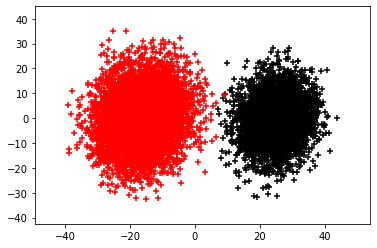

In [43]:
plot_cluster(R, R_label, nr_cls)

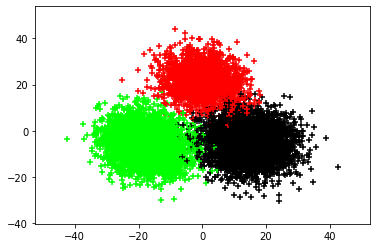

In [44]:
plot_cluster(D, D_label, nd_cls)

# Semi-Synthetic

In [23]:
# load real world data from file

data_path = './data/paired_small.json'

with open(data_path, 'r', encoding='utf8') as f:
    data_dic = json.loads(f.read())
    
data = np.array(data_dic['data'], dtype='float32')

D = data[:, :data_dic['donor_dim']]
R = data[:, data_dic['recipientID_col']+1:data_dic['recipientID_col']+1+data_dic['recipient_dim']]
y = data[:, -1]

X = np.hstack([D, R, y.reshape((-1, 1))])

In [31]:
gm_D = GaussianMixture(n_components=3)
D_clus = gm_D.fit_predict(D)
gm_R = GaussianMixture(n_components=2)
R_clus = gm_R.fit_predict(R)

sum_y = np.zeros((2, 3))
count = np.zeros((2, 3))
for i in range(len(D)):
    d_clus = D_clus[i]
    r_clus = R_clus[i]
    sum_y[r_clus, d_clus] += y[i]
    count[r_clus, d_clus] += 1

y_means = sum_y / count
print(y_means)
print(count)

[[ 340.4         943.54901961  919.03458647]
 [1105.953125   1540.00772201 1246.82765708]]
[[  15.   51.  665.]
 [  64.  259. 3406.]]


In [32]:
Y = np.zeros((len(y), 3))
for i in range(len(y)):
    d_clus = D_clus[i]
    r_clus = R_clus[i]
    
    ys = np.random.normal(y_means[r_clus], [10, 10, 10])
    ys[d_clus] = y[i]
    
    Y[i] = ys
print(Y[:10])

[[1113.93133546 4882.         1258.35100197]
 [1093.28883674 1755.         1243.52603743]
 [1096.29404261 1522.84226605 2525.        ]
 [1107.05689462 1529.57630847 3842.        ]
 [ 350.88156551  956.90534776 2220.        ]
 [ 334.74163875  929.31173114 3918.        ]
 [1119.84058914 1535.93978897 3230.        ]
 [1102.77581822 1560.60049087 3990.        ]
 [1108.95288779 1533.44899849 2275.        ]
 [ 352.91451221  940.2301231  3923.        ]]


In [33]:
Y_means = np.zeros((2, 3))
Y_count = np.zeros((2, 3))
for i in range(len(Y)):
    Y_means[R_clus[i]] += Y[i]
    Y_count[R_clus[i]] += 1
Y_means /= Y_count
print(Y_means)

[[ 340.96332329  943.27290351  919.07293759]
 [1105.88776857 1539.67334226 1246.86245769]]


In [37]:
data = np.hstack([D, R, Y, D_clus.reshape(-1, 1)])
print(data.shape)
print(data_dic['donor_dim']+data_dic['recipient_dim']+3+1)

semi_syn = {}
semi_syn['data'] = list(map(lambda x: list(x), data))
semi_syn['size'] = len(Y)
semi_syn['donor_dim'] = data_dic['donor_dim']
semi_syn['recipient_dim'] = data_dic['recipient_dim']
semi_syn['recipientID_col'] = data_dic['donor_dim'] - 1
semi_syn['fully_observed'] = 1
semi_syn['n_class'] = 3

(4460, 87)
87


In [38]:
with open('./data/paired_full.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(semi_syn, ensure_ascii=False))